In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

from pearls.analyze import (load_dfs, make_plot_data, 
                            extract_series, reduce_learning_curves)

In [1]:
import numpy as np

In [2]:
np.percentile([0.4], 100/3)

0.4

In [3]:
np.percentile([0.4, 0.5], 100/3)

0.43333333333333335

In [4]:
np.percentile([0.4, 0.5, 0.9], 100/3)

0.4666666666666667

In [5]:
np.percentile([0.4, 0.5, 0.9, 0.2], 100/3)

0.4

In [4]:
golden_ratio = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / golden_ratio)

In [5]:
# figures_dir = Path.home().joinpath("OneDrive", "Documents", "internship-end-talk")
# figures_dir.mkdir(parents=True, exist_ok=True)

In [6]:

# sns.set_style("ticks")
# sns.set_context("talk")
# sns.set_palette("colorblind")

# plt.rc('figure', figsize=golden_size(20))
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)

In [7]:
width_pt = 3 * 234.8775 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27 # Convert pt to inches
width = width_pt * inches_per_pt # width in inches

rc = {
    "figure.figsize": golden_size(width),
    "font.serif": ['Times New Roman'],
    "text.usetex": True,
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "font.size": 18,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": "medium",
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
}

sns.set(context="notebook",
        style="ticks",
        palette="colorblind",
        font="serif",
        rc=rc)

In [8]:
with open("results_1000.pkl", "rb") as fh:
    result = pkl.load(fh)

In [9]:
def dataframe_from_result(result):

    rows = []
    for task, config_id in enumerate(result.data):

        d = result.data[config_id]
        bracket, _, _ = config_id        

        for epoch in d.results:

            rows.append(dict(task=task, 
                             bracket=bracket, 
                             epoch=int(epoch), 
                             error=d.results[epoch]['loss'],
                             submitted=d.time_stamps[epoch]['submitted'],
                             runtime=d.time_stamps[epoch]['finished']))

    return pd.DataFrame(rows)

In [10]:
df = dataframe_from_result(result)
assert df.sort_values(["task", "epoch"]).groupby("task").head(n=1).submitted.is_monotonic_increasing

In [11]:
rung_completions = df[df.bracket == 0].sort_values("runtime", ascending=False).drop_duplicates("epoch").sort_values("epoch").runtime.values
rung_completions

array([ 16.33,  48.67,  88.5 , 134.38])

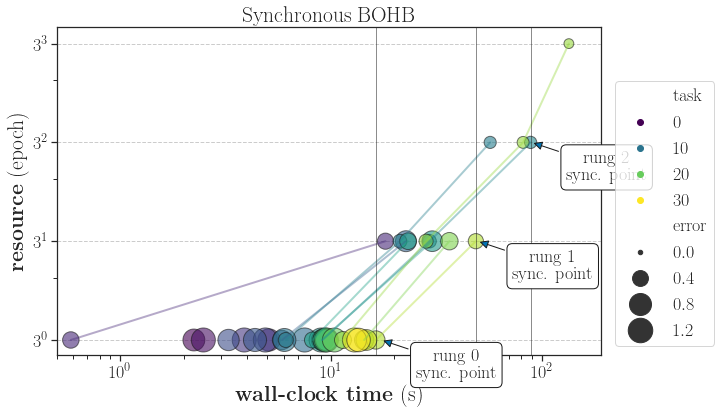

In [12]:
fig, ax1 = plt.subplots()

ax1.set_title("Synchronous BOHB")

bbox_extra_artists = []

sns.lineplot(x="runtime", y="epoch", hue="task", palette="viridis", 
             data=df[(df.runtime < 150) & (df.bracket == 0)], linewidth=2, alpha=0.4, legend=False, ax=ax1)

sns.scatterplot(x="runtime", y="epoch", hue="task", palette="viridis", 
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=df[(df.runtime < 150) & (df.bracket == 0)], linewidth=1.0, edgecolor="k", alpha=0.6, ax=ax1)

ax1.grid(True, which="major", axis="y", linestyle="--")
# ax1.set_ylim(0.00001, 53)

lgd = ax1.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
bbox_extra_artists.append(lgd)
# ax1.set_yticks(resources)
# ax1.set_yticklabels(resources)

ax1.set_yscale('log', basey=3)
ax1.set_xscale('log')

ax1.set_xlabel(r"\textbf{wall-clock time} (s)")
ax1.set_ylabel(r"\textbf{resource} (epoch)")

ax1.set_xlim(5e-1, 190)

for rung, t in enumerate(rung_completions[:-1]):
    ax1.axvline(x=t, linewidth=1.0, color='k', alpha=0.5)
    annotation = ax1.annotate(f'rung {rung}\nsync. point',
                              xy=(t+1, 3**rung), xycoords='data',
                              xytext=(75, -25), textcoords='offset points',
                              va="center", ha="center",
                              bbox=dict(boxstyle="round", fc="w", ec="k"),
                              arrowprops=dict(arrowstyle="-|>", edgecolor='k',
                                              connectionstyle="arc3"))
    bbox_extra_artists.append(annotation)
    
# plt.show()
plt.savefig("hyperband_synchronous.pgf", bbox_extra_artists=bbox_extra_artists, bbox_inches='tight')
# plt.savefig("hyperband_synchronous.png")

In [13]:
EXPERIMENT = "bohb_surrogates"

experiments = [EXPERIMENT]
datasets = ["letter"]
schedulers = ["hyperband_stopping"]
searchers = ["model"]
num_nodes = ["num_nodes_4"]
instance_types = ["m4.xlarge"]
num_threads = ["num_threads_4"]

max_epochs = 27
eta = 3
resources = [min(eta**i, max_epochs) for i in range(4)]
hue_order = list(map(r'$r={}$'.format, resources))

# set this to `None` for quicker results. Set this to `95` for better
# estimation of uncertainty across individual runs.
ci = None

In [14]:
def resources(eta, max_epochs, start=0, end=None):
    if end is None:
        end = int(np.ceil(np.log(max_epochs) / np.log(eta))) + 1
    return [min(eta**i, max_epochs) for i in range(start, end)]

In [15]:
resources(eta, max_epochs, start=3)

[27]

In [16]:
resources(eta, max_epochs, end=3)

[1, 3, 9]

In [17]:
# Downloaded from:
# autogluon-benchmarks-v2-142186002571-us-west-2/autogluon_experiments/results
df_tree_root = load_dfs(experiments, datasets, schedulers, searchers,
                        num_nodes, instance_types, num_threads,
                        base_dir="../datasets/results")
df_tree = df_tree_root[EXPERIMENT]

In [18]:
data = make_plot_data(df_tree)

Processing results for dataset [letter], optimizer [hyperband_stopping.model.num_nodes_4.m4.xlarge.num_threads_4] (nbr. runs 1)...


In [27]:
data.bracket.unique()

array([0])

In [19]:
new_data = data.rename(columns=dict(task_id="task"))

In [20]:
straggler = new_data[(new_data.runtime > 30) & (new_data.task < 5) & (new_data.epoch == 1)]

In [21]:
straggler_xy = np.hstack([straggler.runtime.values, straggler.epoch.values-0.1])
straggler_xy

array([], dtype=float64)

In [22]:
solid_data = new_data.groupby("bracket") \
                     .apply(lambda g: g[g.epoch.isin(resources(eta, max_epochs, start=g.name))]) \
                     .reset_index(drop=True)

In [23]:
dashed_data = new_data.groupby("bracket") \
                      .apply(lambda g: g[g.epoch.isin(resources(eta, max_epochs, end=g.name))]) \
                      .reset_index(drop=True)

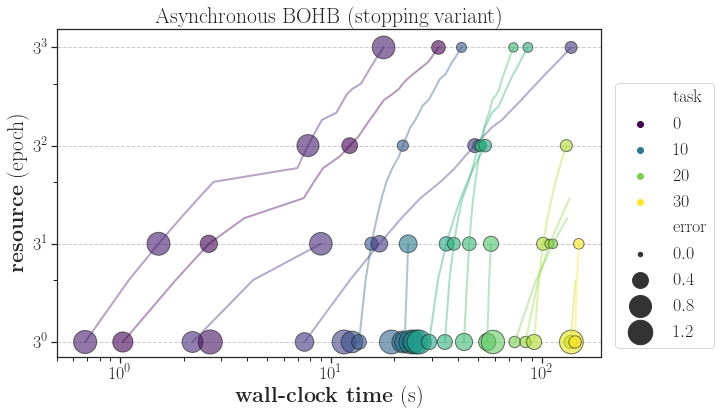

In [24]:
fig, ax1 = plt.subplots()

ax1.set_title("Asynchronous BOHB (stopping variant)")

sns.lineplot(x="runtime", y="epoch", hue="task", palette="viridis", 
             data=new_data[new_data.runtime < 150], linewidth=2, alpha=0.4, legend=False, ax=ax1)

# sns.scatterplot(x="runtime", y="epoch", hue="task", palette="viridis", 
#                 size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
#                 data=dashed_data[dashed_data.runtime < 300], 
#                 linestyle='--', linewidth=1.0, edgecolor="k", alpha=0.6, ax=ax1)

sns.scatterplot(x="runtime", y="epoch", hue="task", palette="viridis", 
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=solid_data[solid_data.runtime < 150], 
                linewidth=1.0, edgecolor="k", alpha=0.6, ax=ax1)

ax1.grid(True, which="major", axis="y", linestyle="--")
# ax1.set_ylim(0.00001, 53)

lgd = ax1.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
# ax1.set_yticks(resources)
# ax1.set_yticklabels(resources)

ax1.set_yscale('log', basey=3)
ax1.set_xscale('log')

ax1.set_xlabel(r"\textbf{wall-clock time} (s)")
ax1.set_ylabel(r"\textbf{resource} (epoch)")

ax1.set_xlim(5e-1, 190)
# ax1.annotate('straggler',
#              xy=straggler_xy, xycoords='data',
#              xytext=(-70, -40), textcoords='offset points',
#              arrowprops=dict(arrowstyle="->", edgecolor='k',
#                              connectionstyle="angle,angleA=0,angleB=90,rad=10"))
# 
# plt.show()
plt.savefig("hyperband_stopping.pgf", bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig("hyperband_stopping.png")

In [42]:
[result.data[config_id].results for config_id in result.data]

[{1.0: {'loss': 0.7930976430976431, 'info': {}}},
 {1.0: {'loss': 0.9615126050420169, 'info': {}}},
 {1.0: {'loss': 0.8274701228749368, 'info': {}}},
 {1.0: {'loss': 0.43394969182075627, 'info': {}},
  3.0: {'loss': 0.4171247709478594, 'info': {}}},
 {1.0: {'loss': 0.9631932773109244, 'info': {}}},
 {1.0: {'loss': 0.9663865546218487, 'info': {}}},
 {1.0: {'loss': 0.7489119517910947, 'info': {}}},
 {1.0: {'loss': 0.8863636363636364, 'info': {}}},
 {1.0: {'loss': 0.6125566560349169, 'info': {}},
  3.0: {'loss': 0.7204968944099379, 'info': {}}},
 {1.0: {'loss': 0.9663299663299664, 'info': {}}},
 {1.0: {'loss': 0.8781144781144781, 'info': {}}},
 {1.0: {'loss': 0.35429242119382964, 'info': {}},
  3.0: {'loss': 0.2940979208584842, 'info': {}},
  9.0: {'loss': 0.21981891348088534, 'info': {}}},
 {1.0: {'loss': 0.3936026936026936, 'info': {}},
  3.0: {'loss': 0.2845117845117845, 'info': {}},
  9.0: {'loss': 0.22609427609427613, 'info': {}}},
 {1.0: {'loss': 0.9566386554621849, 'info': {}}},
 {

In [24]:
result.get_pandas_dataframe()[0]

batch_size  dropout_1  dropout_2  learning_rate  n_units_1  n_units_2  \
0            18   0.502766   0.963313       0.001040         37         77   
1            17   0.736660   0.111857       0.092833        333        220   
2            13   0.857504   0.019255       0.010424        395        742   
3            87   0.609249   0.087452       0.027839        919         70   
4            87   0.609249   0.087452       0.027839        919         70   
..          ...        ...        ...            ...        ...        ...   
385          83   0.659259   0.043071       0.001942        152       1019   
386          19   0.771564   0.090559       0.000992        276        430   
387          60   0.101485   0.665779       0.000332         62        235   
388          48   0.477540   0.231466       0.000456        885        633   
389          30   0.442320   0.100259       0.000569        307        490   

      scale_1   scale_2  budget  
0    0.320106  2.635415     1.0  
1    0.639071  0.004195     1.0  
2    0.205782  0.691850     1.0  
3    0.311742  0.047602     3.0  
4    0.311742  0.047602     3.0  
..        ...       ...     ...  
385  0.935339  0.006656    27.0  
386  0.874192  0.014193    27.0  
387  0.100099  0.422590    27.0  
388  3.385690  0.002657    27.0  
389  7.705150  0.002555    27.0  

[390 rows x 9 columns]

In [33]:
all_runs


%run:
 Run the named file inside IPython as a program.

Usage::

  %run [-n -i -e -G]
       [( -t [-N<N>] | -d [-b<N>] | -p [profile options] )]
       ( -m mod | file ) [args]

Parameters after the filename are passed as command-line arguments to
the program (put in sys.argv). Then, control returns to IPython's
prompt.

This is similar to running at a system prompt ``python file args``,
but with the advantage of giving you IPython's tracebacks, and of
loading all variables into your interactive namespace for further use
(unless -p is used, see below).

The file is executed in a namespace initially consisting only of
``__name__=='__main__'`` and sys.argv constructed as indicated. It thus
sees its environment as if it were being run as a stand-alone program
(except for sharing global objects such as previously imported
modules). But after execution, the IPython interactive namespace gets
updated with all variables defined in the program (except for __name__
and sys.argv). This allows 

/usr/local/lib/python3.6/dist-packages/IPython/core/magics/execution.py:699: UserWarning: you must provide at least a filename.
  warn('you must provide at least a filename.')


In [32]:
[run.config_id for run in all_runs]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 8),
 (0, 0, 9),
 (0, 0, 10),
 (0, 0, 11),
 (0, 0, 11),
 (0, 0, 11),
 (0, 0, 12),
 (0, 0, 12),
 (0, 0, 12),
 (0, 0, 13),
 (0, 0, 14),
 (0, 0, 14),
 (0, 0, 15),
 (0, 0, 15),
 (0, 0, 16),
 (0, 0, 17),
 (0, 0, 18),
 (0, 0, 19),
 (0, 0, 20),
 (0, 0, 21),
 (0, 0, 21),
 (0, 0, 22),
 (0, 0, 22),
 (0, 0, 22),
 (0, 0, 22),
 (0, 0, 23),
 (0, 0, 23),
 (0, 0, 24),
 (0, 0, 25),
 (0, 0, 26),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 0, 8),
 (1, 0, 8),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 5),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 0, 4),
 (4, 0, 4),
 (4, 0, 5),
 (4, 0, 6),
 (4, 0, 7),
 (4, 0, 8),
 (4, 0, 9),
 (4, 0, 9),
 (4, 0, 10),
 (4, 0, 11),
 (4, 0, 11

In [7]:
# get all executed runs
all_runs = result.get_all_runs()

In [8]:
# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()

In [9]:
# Here is how you get he incumbent (best configuration)
inc_id = result.get_incumbent_id()

In [10]:
# let's grab the run on the highest budget 
inc_runs = result.get_runs_by_id(inc_id)
inc_run = inc_runs[-1]

In [15]:
inc_run.info

{}

In [21]:
all_runs[0]

config_id: (0, 0, 0)	budget: 1.000000	loss: 0.7930976430976431
time_stamps: 0.007715463638305664 (submitted), 0.007905721664428711 (started), 2.2395179271698 (finished)
info: {}

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd10d9eb0f0>)

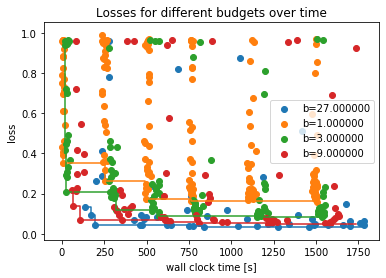

In [16]:
hpvis.losses_over_time(all_runs) 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd10d90dba8>)

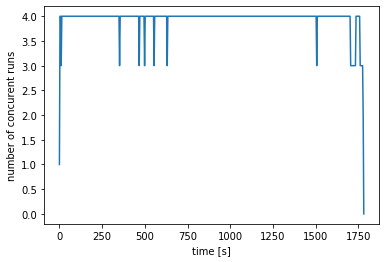

In [17]:
# the number of concurent runs,
hpvis.concurrent_runs_over_time(all_runs) 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd10d262c50>)

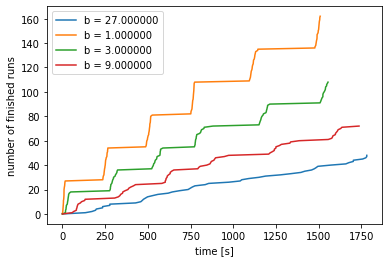

In [18]:
# and the number of finished runs.
hpvis.finished_runs_over_time(all_runs)

(<Figure size 432x288 with 8 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd10d168cc0>,
       dtype=object))

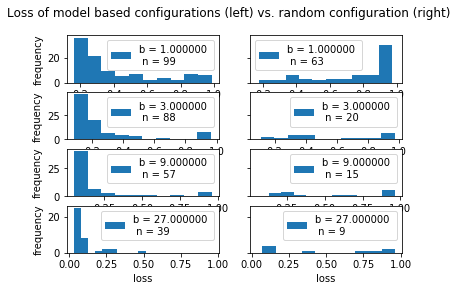

In [19]:
# For model based optimizers, one might wonder how much the model actually helped.
# The next plot compares the performance of configs picked by the model vs. random ones
hpvis.performance_histogram_model_vs_random(all_runs, id2conf) 

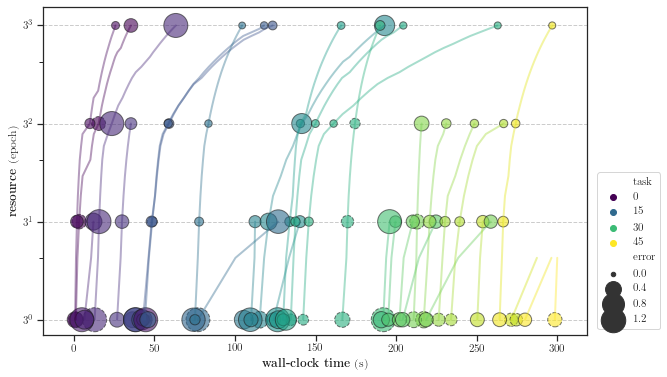

In [211]:
fig, ax1 = plt.subplots()

sns.lineplot(x="runtime", y="epoch", hue="task", palette="viridis", 
             data=new_data[new_data.runtime < 300], linewidth=2, alpha=0.4, legend=False, ax=ax1)

sns.scatterplot(x="runtime", y="epoch", hue="task", palette="viridis", 
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=dashed_data[dashed_data.runtime < 300], 
                linestyle='--', linewidth=1.0, edgecolor="k", alpha=0.6, ax=ax1)

sns.scatterplot(x="runtime", y="epoch", hue="task", palette="viridis", 
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=solid_data[solid_data.runtime < 300], legend=False,
                linewidth=1.0, edgecolor="k", alpha=0.6, ax=ax1)

ax1.grid(True, which="major", axis="y", linestyle="--")
# ax1.set_ylim(0.00001, 53)

lgd = ax1.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
# ax1.set_yticks(resources)
# ax1.set_yticklabels(resources)

ax1.set_yscale('log', basey=3)

ax1.set_xlabel(r"\textbf{wall-clock time} (s)")
ax1.set_ylabel(r"\textbf{resource} (epoch)")

plt.show()
# plt.savefig("hyperband_stopping.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig("hyperband_stopping.png")

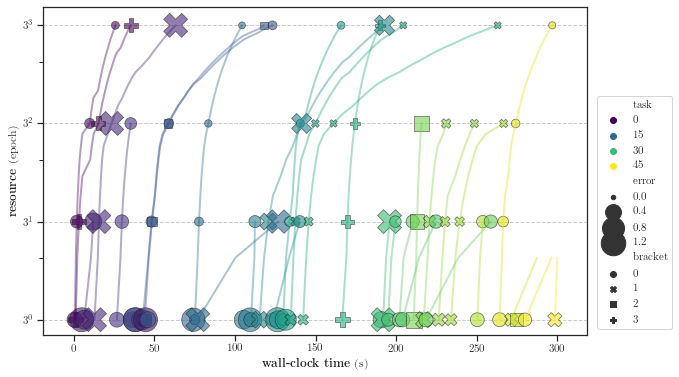

In [61]:
fig, ax1 = plt.subplots()

sns.lineplot(x="runtime", y="epoch", hue="task", palette="viridis", 
             data=new_data[before_time], linewidth=2, alpha=0.4, legend=False, ax=ax1)

sns.scatterplot(x="runtime", y="epoch", hue="task", style="bracket", palette="viridis", 
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=new_data[rungs_only & before_time], edgecolor="k", alpha=0.6, ax=ax1)

ax1.grid(True, which="major", axis="y", linestyle="--")
# ax1.set_ylim(0.00001, 53)

lgd = ax1.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0))
# ax1.set_yticks(resources)
# ax1.set_yticklabels(resources)

ax1.set_yscale('log', basey=3)

ax1.set_xlabel(r"\textbf{wall-clock time} (s)")
ax1.set_ylabel(r"\textbf{resource} (epoch)")

plt.show()
# plt.savefig("hyperband_stopping.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig("hyperband_stopping.png")

In [101]:
np.log(1e-8)

-18.420680743952367

In [ ]:
g = sns.relplot(x="runtime", y="epoch", hue="task", size="error", row="scheduler",
            sizes=(20, 600), data=new_data[ind], kind="scatter", edgecolor="k", alpha=0.6, 
            height=8, aspect=golden_ratio, palette="viridis")
g.map(sns.lineplot, "runtime", "epoch", "task", linewidth=2, alpha=0.2, palette="viridis")
# g.set(ylim=(2/3, 35))
g.set_axis_labels("wall clock time (s)", "resource (epoch)")
g.set(yticks=resources)
# g.facet_axis(0, 0).set_yscale("log", basey=3)
# g.map(sns.scatterplot, "runtime", "epoch", "error")

In [205]:
log_b = lambda a, b: np.floor_divide(np.log(a), np.log(b))

rung_to_resource [[0.]
 [1.]]
resource_to_rung [[0.9]
 [3.1]]
resource_to_rung [ 0.1 30. ]
resource_to_rung [ 0.1 30. ]
rung_to_resource [0. 0.]
rung_to_resource [-2.1 -2.1  3.1  3.1]
resource_to_rung [ 0.1 30. ]
rung_to_resource [0. 0.]
rung_to_resource [-2.1 -2.1  3.1  3.1]
resource_to_rung [ 0.1 30. ]
rung_to_resource [0. 0.]
rung_to_resource [-2.1 -2.1  3.1  3.1]
resource_to_rung [ 0.1 30. ]
resource_to_rung [ 0.1 30. ]
rung_to_resource [0. 0.]
rung_to_resource [-2.1 -2.1  3.1  3.1]
rung_to_resource [0. 0.]
rung_to_resource [0. 0.]
rung_to_resource [0. 0.]
rung_to_resource []
rung_to_resource [[0]
 [1]
 [2]
 [3]]
rung_to_resource [[-2.1]
 [ 3.1]]
rung_to_resource [[-2.1]
 [ 3.1]]
rung_to_resource [[0]]
rung_to_resource [[1]]
rung_to_resource [[2]]
rung_to_resource [[3]]
rung_to_resource [0.]
rung_to_resource [1.]
rung_to_resource [2.]
rung_to_resource [3.]
rung_to_resource [0.]
rung_to_resource [0.]
rung_to_resource [0.]
rung_to_resource [1.]
rung_to_resource [1.]
rung_to_resource 

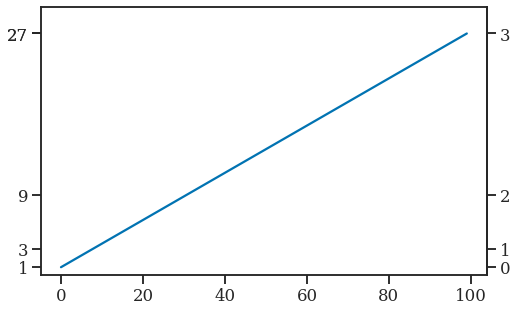

In [206]:
fig, ax = plt.subplots(figsize=golden_size(8))

ax.plot(np.arange(100), np.linspace(1, 27, 100))

ax.set_yticks(resources)
ax.set_yticklabels(resources)
ax.set_ylim(0.1, 30)

def rung_to_resource(rung):
    print("rung_to_resource", rung)
    return 3 ** rung

def resource_to_rung(resource):
    print("resource_to_rung", resource)
    return np.log(resource) / np.log(3)

ax2 = ax.secondary_yaxis('right', functions=(resource_to_rung, rung_to_resource))

ax2.set_ticks(range(4))

plt.show()

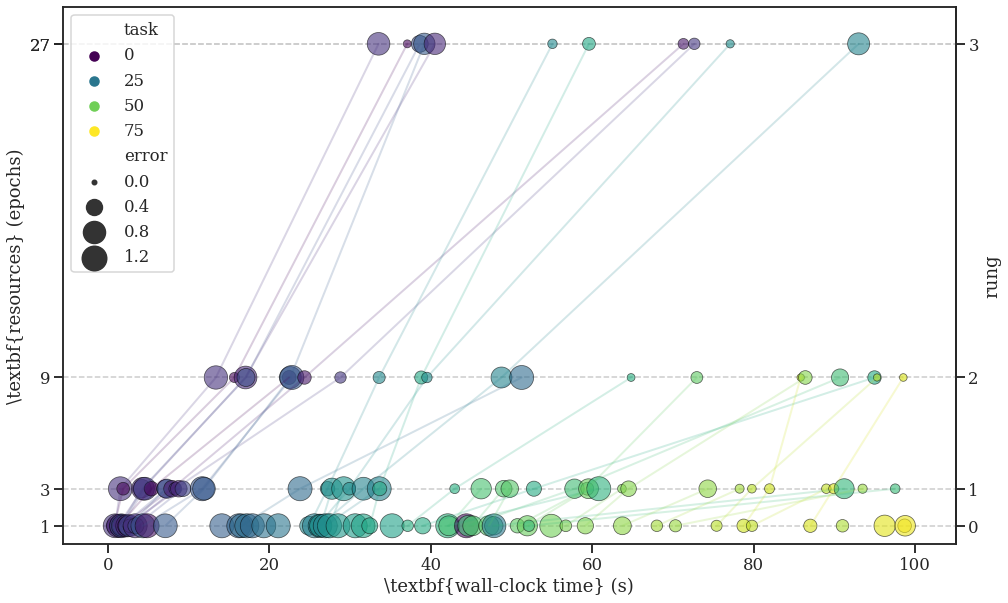

In [221]:
fig, ax1 = plt.subplots(figsize=golden_size(16))

sns.lineplot(x="runtime", y="epoch", hue="task", palette="viridis", 
             data=new_data[ind], linewidth=2, alpha=0.2, legend=False, ax=ax1)

sns.scatterplot(x="runtime", y="epoch", hue="task", palette="viridis",
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=new_data[ind], edgecolor="k", alpha=0.6, ax=ax1)

# ax1.legend(loc='lower left', bbox_to_anchor=(1,0.5))
ax1.set_yticks(resources)
ax1.set_yticklabels(resources)
ax1.set_ylim(0.001, 29)

ax1.grid(True, which="both", axis="y", linestyle="--")

# ax.set_xscale('log')
# ax.set_yscale('log', basey=3)

ax1.set_xlabel(r"\textbf{wall-clock time} (s)")
ax1.set_ylabel(r"\textbf{resources} (epochs)")

def rung_to_resource(rung):
    return 3 ** rung

def resource_to_rung(resource):
    return np.log(resource) / np.log(3)

ax2 = ax1.secondary_yaxis('right', functions=(resource_to_rung, rung_to_resource))
ax2.set_ticks(range(4))
ax2.set_ylabel("rung")

plt.show()
# plt.savefig(str(figures_dir.joinpath("hyperband_promotion.pdf")))
# plt.savefig(str(figures_dir.joinpath("hyperband_promotion.png")))

In [54]:
# new_data = data[data.task_id < 14]
new_data = data[data.runtime < 35]

In [39]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    observed = (runtime <= 33)
    observed_new = ~observed & (runtime < 35)

    ax.scatter(task_id[ind & observed], epoch[ind & observed], error[ind & observed], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

    ax.scatter(task_id[ind & observed_new], epoch[ind & observed_new], error[ind & observed_new], 
               marker='P', s=16**2, edgecolor='k', alpha=1.0, **kwargs)

    task_id = int(kwargs.get("label"))
    if task_id == 4:
        ax.scatter(task_id, 27, 0.1, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 5:
        ax.scatter(task_id, 27, 0.1, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 13:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    

{'color': (0.276022, 0.044167, 0.370164), 'label': '0'}
{'color': (0.281924, 0.089666, 0.412415), 'label': '1'}
{'color': (0.283187, 0.125848, 0.44496), 'label': '3'}
{'color': (0.280255, 0.165693, 0.476498), 'label': '4'}
{'color': (0.274128, 0.199721, 0.498911), 'label': '5'}
{'color': (0.263663, 0.237631, 0.518762), 'label': '6'}
{'color': (0.252194, 0.269783, 0.531579), 'label': '7'}
{'color': (0.237441, 0.305202, 0.541921), 'label': '8'}
{'color': (0.223925, 0.334994, 0.548053), 'label': '9'}
{'color': (0.208623, 0.367752, 0.552675), 'label': '10'}
{'color': (0.19586, 0.395433, 0.555276), 'label': '11'}
{'color': (0.182256, 0.426184, 0.55712), 'label': '12'}
{'color': (0.171176, 0.45253, 0.557965), 'label': '13'}
{'color': (0.159194, 0.482237, 0.558073), 'label': '14'}
{'color': (0.149039, 0.508051, 0.55725), 'label': '15'}
{'color': (0.13777, 0.537492, 0.554906), 'label': '16'}
{'color': (0.127568, 0.566949, 0.550556), 'label': '17'}
{'color': (0.121148, 0.592739, 0.544641), 'lab

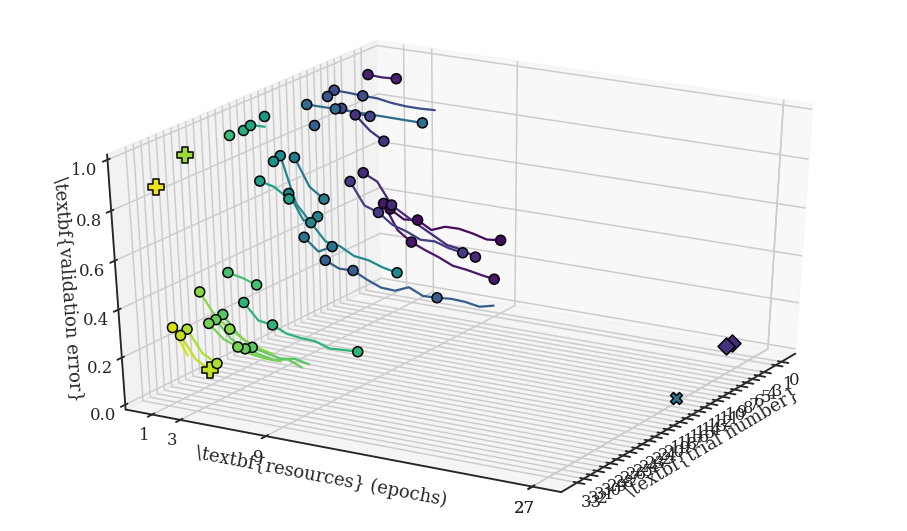

In [40]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
# g.savefig(str(figures_dir.joinpath("model_state_1.pdf")))
# g.savefig(str(figures_dir.joinpath("model_state_1.png")))

In [13]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    observed = (runtime <= 33)
    observed_new = ~observed & (runtime < 35)

    ax.scatter(task_id[ind & observed], epoch[ind & observed], error[ind & observed], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

    ax.scatter(task_id[ind & observed_new], epoch[ind & observed_new], error[ind & observed_new], 
               marker='P', s=16**2, edgecolor='k', alpha=1.0, **kwargs)

    task_id = int(kwargs.get("label"))
    if task_id == 4:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 5:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 13:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)     

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


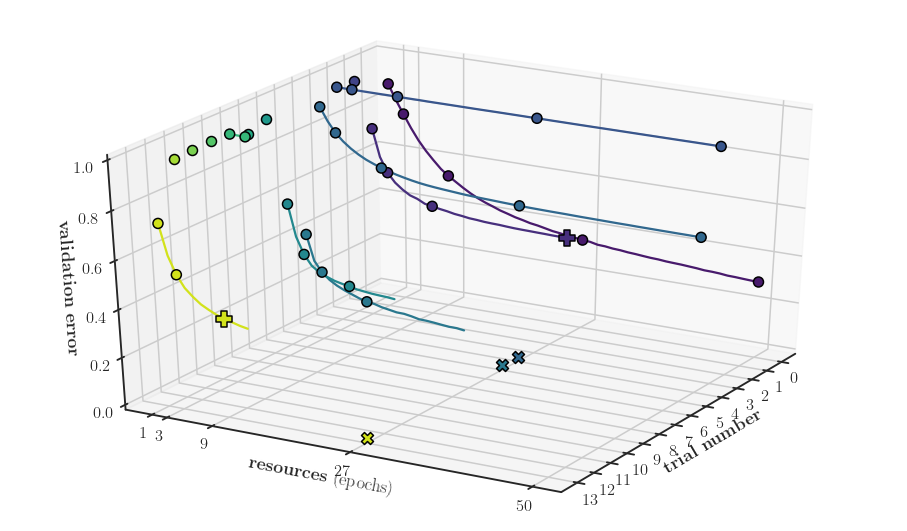

In [14]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_2.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_2.png")))

In [15]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    ax.scatter(task_id[ind], epoch[ind], error[ind], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

    task_id = int(kwargs.get("label"))
    if task_id == 4:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 5:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 13:
        ax.scatter(task_id, 27, 0, marker='X', s=12**2, edgecolor='k', alpha=1.0, **kwargs)     

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


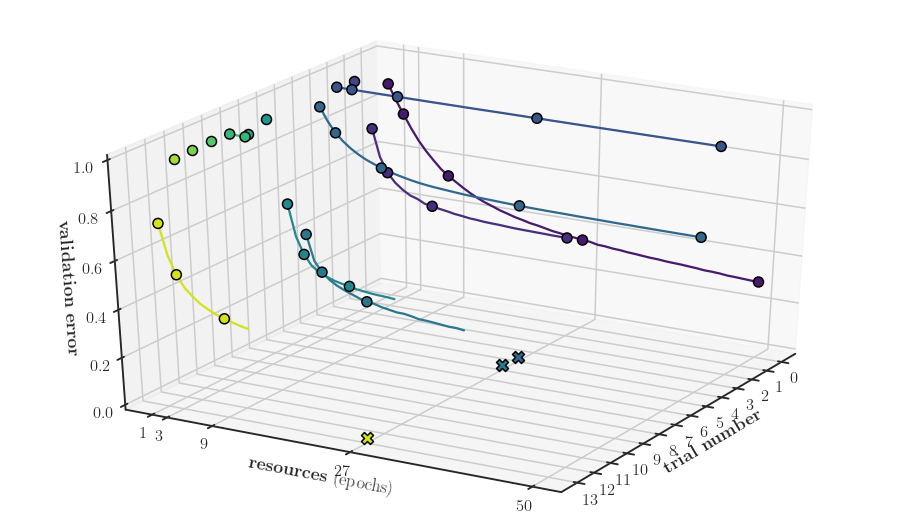

In [16]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_3.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_3.png")))

In [17]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    ax.scatter(task_id[ind], epoch[ind], error[ind], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

    task_id = int(kwargs.get("label"))
    if task_id == 4:
        ax.scatter(task_id, 27, 0.12, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 5:
        ax.scatter(task_id, 27, 0.1, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 13:
        ax.scatter(task_id, 27, 0.3, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


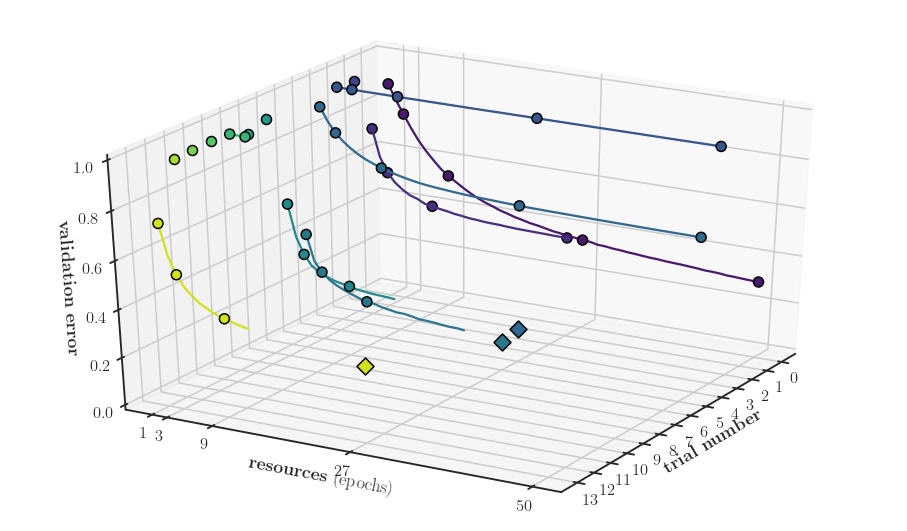

In [18]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_4.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_4.png")))

In [19]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    observed = (runtime <= 33)
    observed_new = ~observed & (runtime < 35)

    ax.scatter(task_id[ind], epoch[ind], error[ind], edgecolor='k', s=10**2, alpha=1.0, **kwargs)

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


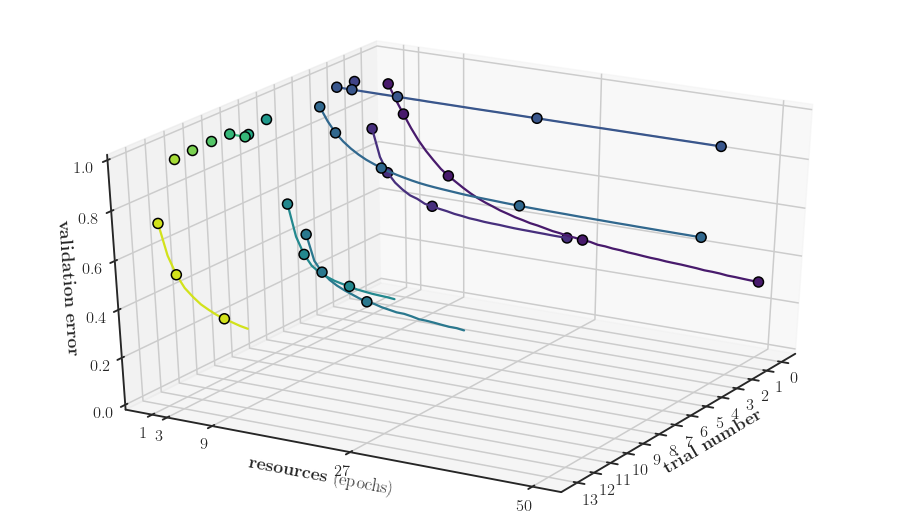

In [20]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_all_rungs.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_all_rungs.png")))

In [21]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
#     ind = epoch.isin(resources)

    observed = (runtime <= 33)
    observed_new = ~observed & (runtime < 35)

    ax.scatter(task_id, epoch, error, s=10**2, edgecolor='k', alpha=1.0, **kwargs)

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


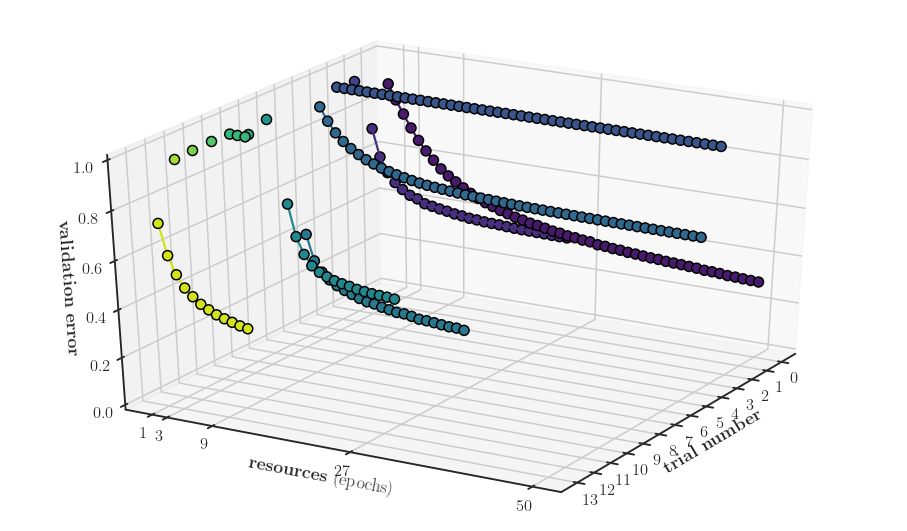

In [22]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_all_epochs.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_all_epochs.png")))

In [23]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    ax.scatter(task_id[ind], epoch[ind], error[ind], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

    task_id = int(kwargs.get("label"))
    if task_id == 4:
        ax.scatter(task_id, 27, 0.12, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 5:
        ax.scatter(task_id, 27, 0.1, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 13:
        ax.scatter(task_id, 27, 0.3, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


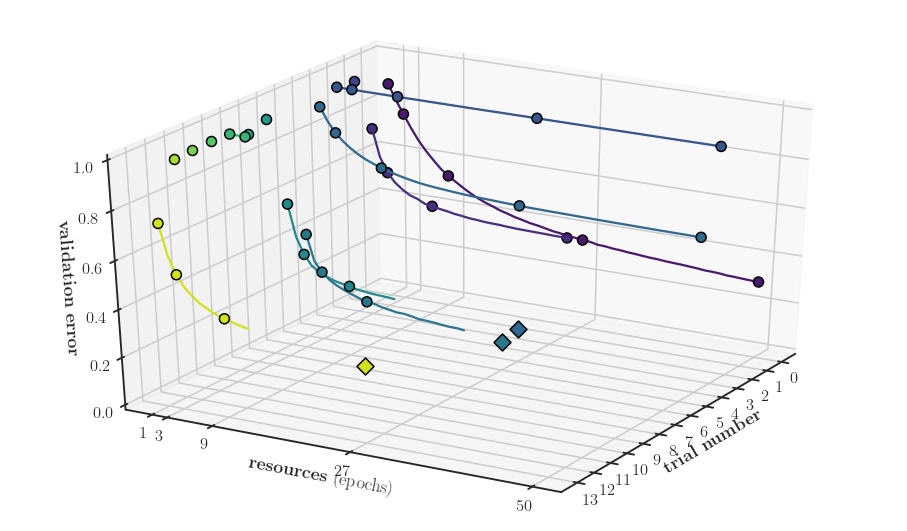

In [24]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_pending_next.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_pending_next.png")))

In [25]:
def fn(task_id, epoch, error, runtime, **kwargs):

    print(kwargs)
    ax = plt.gca()
    ind = epoch.isin(resources)

    ax.scatter(task_id[ind], epoch[ind], error[ind], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

    task_id = int(kwargs.get("label"))
    if task_id == 4:
        ax.scatter(task_id, 27, 0.12, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
        ax.scatter(task_id, 50, 0.05, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
    if task_id == 5:
        ax.scatter(task_id, 27, 0.1, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)   
        ax.scatter(task_id, 50, 0.02, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)
    if task_id == 13:
        ax.scatter(task_id, 27, 0.3, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)    
        ax.scatter(task_id, 50, 0.12, marker='D', s=12**2, edgecolor='k', alpha=1.0, **kwargs)

{'color': (0.282656, 0.100196, 0.42216), 'label': '0'}
{'color': (0.277134, 0.185228, 0.489898), 'label': '1'}
{'color': (0.253935, 0.265254, 0.529983), 'label': '2'}
{'color': (0.221989, 0.339161, 0.548752), 'label': '3'}
{'color': (0.190631, 0.407061, 0.556089), 'label': '4'}
{'color': (0.163625, 0.471133, 0.558148), 'label': '5'}
{'color': (0.139147, 0.533812, 0.555298), 'label': '6'}
{'color': (0.120565, 0.596422, 0.543611), 'label': '7'}
{'color': (0.134692, 0.658636, 0.517649), 'label': '8'}
{'color': (0.20803, 0.718701, 0.472873), 'label': '9'}
{'color': (0.327796, 0.77398, 0.40664), 'label': '10'}
{'color': (0.477504, 0.821444, 0.318195), 'label': '11'}
{'color': (0.647257, 0.8584, 0.209861), 'label': '12'}
{'color': (0.82494, 0.88472, 0.106217), 'label': '13'}


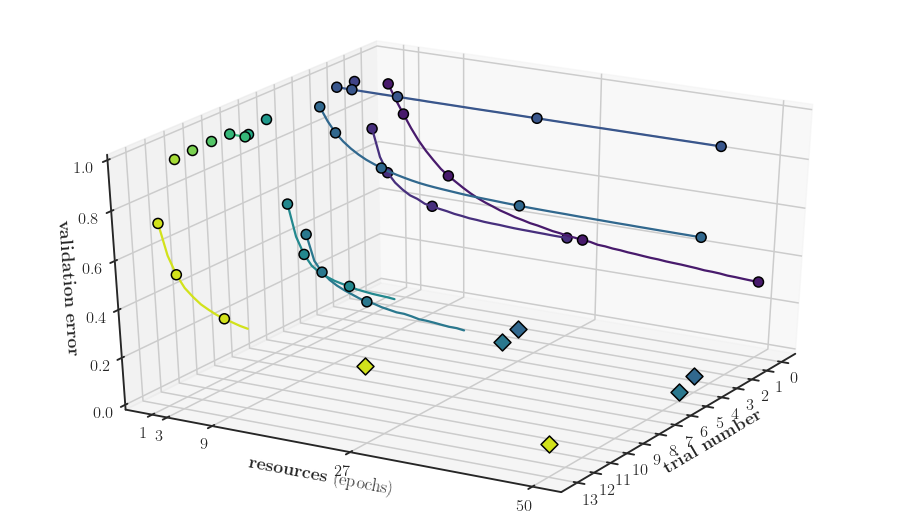

In [26]:
g = sns.FacetGrid(new_data, 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(xticks=new_data.task_id.sort_values().unique(), yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state_pending_next_last.pdf")))
g.savefig(str(figures_dir.joinpath("model_state_pending_next_last.png")))

In [27]:
def fn(task_id, epoch, error, runtime, **kwargs):

    ax = plt.gca()
    ind = epoch.isin(resources)

    ax.scatter(task_id[ind], epoch[ind], error[ind], 
               edgecolor='k', s=10**2, alpha=1.0, **kwargs)

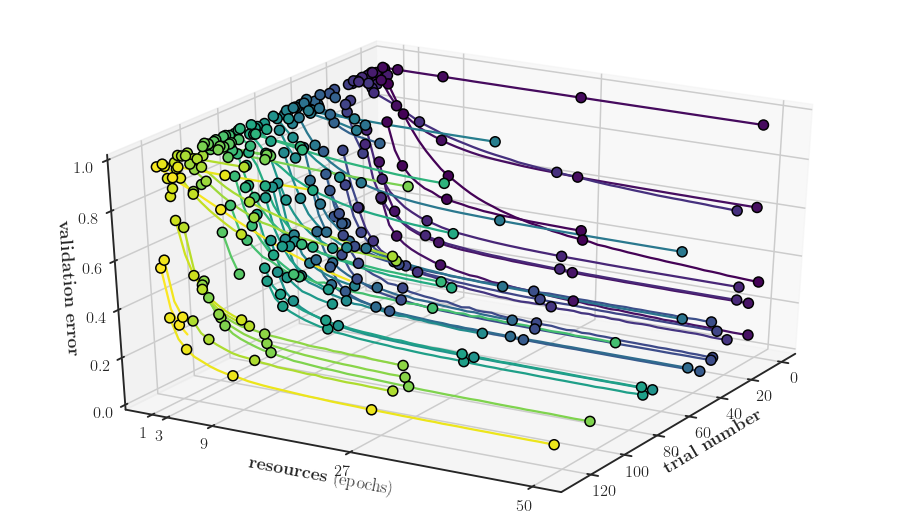

In [28]:
g = sns.FacetGrid(data[data.runtime < 300], 
                  row="scheduler",
                  col="searcher",
                  hue="task_id", 
                  palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))\
       .map(fn, "task_id", "epoch", "error", "runtime") \
       .map(plt.plot, "task_id", "epoch", "error") \
       .set_titles("") \
       .set_xlabels(r"\textbf{trial number}") \
       .set_ylabels(r"\textbf{resources} (epochs)") \
       .set(zlabel=r"\textbf{validation error}") \
       .set(yticks=resources, zlim=(0, 1))
g.savefig(str(figures_dir.joinpath("model_state.pdf")))
g.savefig(str(figures_dir.joinpath("model_state.png")))

In [29]:
new_data = data.rename(columns=dict(task_id="trial"))

In [30]:
ind = new_data.epoch.isin(resources) & (new_data.runtime < 100)

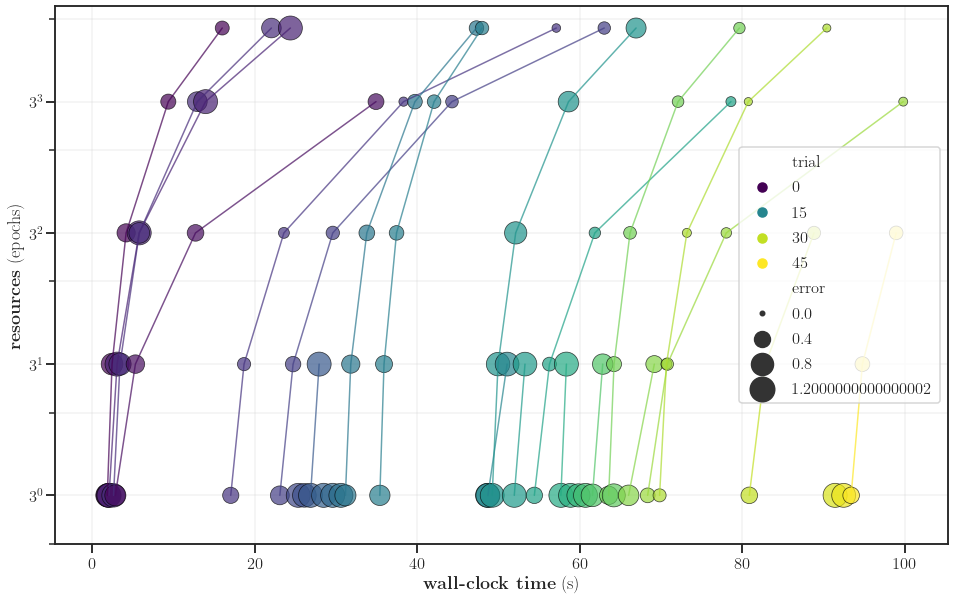

In [31]:
fig, ax = plt.subplots(figsize=golden_size(16))

sns.lineplot(x="runtime", y="epoch", hue="trial", palette="viridis", 
             data=new_data[ind], linewidth=1.5, 
             legend=False, alpha=0.7, ax=ax)

sns.scatterplot(x="runtime", y="epoch", hue="trial", palette="viridis",
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=new_data[ind], edgecolor="k", alpha=0.7, ax=ax)

# ax.legend(loc='lower left', bbox_to_anchor=(1,0.5))

ax.grid(True, which="both", alpha=0.25)

# ax.set_xscale('log')
ax.set_yscale('log', basey=3)
ax.set_ylim(2/3, 60)

ax.set_xlabel(r"\textbf{wall-clock time} (s)")
ax.set_ylabel(r"\textbf{resources} (epochs)")

# plt.show()
plt.savefig(str(figures_dir.joinpath("hyperband_stopping.pdf")))
plt.savefig(str(figures_dir.joinpath("hyperband_stopping.png")))

In [32]:
EXPERIMENT = "bohb_surrogates"

experiments = [EXPERIMENT]
datasets = ["letter"]
schedulers = ["hyperband_promotion"]
searchers = ["random"]
num_nodes = ["num_nodes_4"]
instance_types = ["m4.xlarge"]
num_threads = ["num_threads_4"]

max_epochs = 50
eta = 3
resources = [min(eta**i, max_epochs) for i in range(5)]
hue_order = list(map(r'$r={}$'.format, resources))

# set this to `None` for quicker results. Set this to `95` for better
# estimation of uncertainty across individual runs.
ci = None

In [33]:
# Downloaded from:
# autogluon-benchmarks-v2-142186002571-us-west-2/autogluon_experiments/results
df_tree_root = load_dfs(experiments, datasets, schedulers, searchers,
                        num_nodes, instance_types, num_threads,
                        base_dir="../results")
df_tree = df_tree_root[EXPERIMENT]

In [42]:
data = make_plot_data(df_tree)

Processing results for dataset [letter], optimizer [hyperband_promotion.model.num_nodes_16.m4.xlarge.num_threads_4] (nbr. runs 1)...


In [43]:
new_data = data.rename(columns=dict(task_id="trial"))

In [44]:
ind = new_data.epoch.isin(resources) & (new_data.runtime < 100)

Text(0, 0.5, '\\textbf{resources} (epochs)')

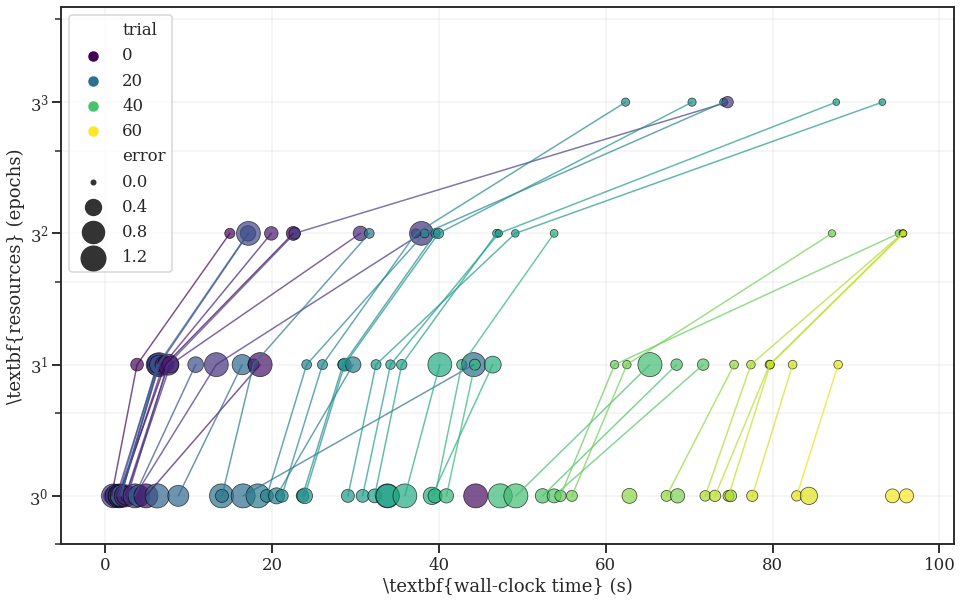

In [45]:
fig, ax = plt.subplots(figsize=golden_size(16))

sns.lineplot(x="runtime", y="epoch", hue="trial", palette="viridis", 
             data=new_data[ind], linewidth=1.5, 
             legend=False, alpha=0.7, ax=ax)

sns.scatterplot(x="runtime", y="epoch", hue="trial", palette="viridis",
                size="error", sizes=(20, 600), size_norm=(0.0, 1.0), 
                data=new_data[ind], edgecolor="k", alpha=0.7, ax=ax)

# ax.legend(loc='lower left', bbox_to_anchor=(1,0.5))

ax.grid(True, which="both", alpha=0.25)

# ax.set_xscale('log')
ax.set_yscale('log', basey=3)
ax.set_ylim(2/3, 60)

ax.set_xlabel(r"\textbf{wall-clock time} (s)")
ax.set_ylabel(r"\textbf{resources} (epochs)")

# plt.show()
# plt.savefig(str(figures_dir.joinpath("hyperband_promotion.pdf")))
# plt.savefig(str(figures_dir.joinpath("hyperband_promotion.png")))

In [42]:
experiments = ["autoff"]
datasets = ["openml_task_31"]
schedulers = ["hyperband_stopping" , "fifo"]
searchers = ["random", "model", "model_exp-decay-combined"]
num_nodes = ["num_nodes_4"]
instance_types = ["m4.xlarge"]
num_threads = ["num_threads_4"]

df_tree = load_dfs(experiments, datasets, schedulers, searchers, 
                  num_nodes, instance_types, num_threads, 
                  base_dir="../aaron_results")

In [43]:
data = make_plot_data(df_tree["autoff"], extract_series_fn=extract_series)

Processing results for dataset [openml_task_31], optimizer [hyperband_stopping.random.num_nodes_4.m4.xlarge.num_threads_4] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [hyperband_stopping.model.num_nodes_4.m4.xlarge.num_threads_4] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [hyperband_stopping.model_exp-decay-combined.num_nodes_4.m4.xlarge.num_threads_4] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [fifo.random.num_nodes_4.m4.xlarge.num_threads_4] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [fifo.model.num_nodes_4.m4.xlarge.num_threads_4] (nbr. runs 30)...


In [44]:
df_tree_hpbandster = load_dfs_hpbandster(experiments, datasets, 
                                         methods=['hb', 'bohb'],
                                         num_nodes=num_nodes, 
                                         base_dir="../aaron_results/synchronous/")

In [62]:
sparse_data = make_plot_data(df_tree["autoff"],
                             process_run_fn=reduce_learning_curves,
                             extract_series_fn=extract_series,
                             optimizer_name_fn="{scheduler}.{searcher}".format)

Processing results for dataset [openml_task_31], optimizer [hyperband_stopping.random] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [hyperband_stopping.model] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [hyperband_stopping.model_exp-decay-combined] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [fifo.random] (nbr. runs 30)...
Processing results for dataset [openml_task_31], optimizer [fifo.model] (nbr. runs 30)...


In [63]:
sparse_data_hpbandster = make_plot_data_hpbandster(
    df_tree_hpbandster["autoff"],
    extract_series_fn=extract_series,
    optimizer_name_fn="{method}".format
)

Processing results for dataset [openml_task_31], optimizer [hb] (nbr. runs 30)...


ValueError: cannot reindex from a duplicate axis

In [92]:
experiments = ["resnet_v2_20"]
datasets = ["cifar10"]
schedulers = ["fifo", "hyperband_stopping"]
searchers = ["random", "model_kernel_exp-decay-combined"]
num_nodes = ["num_nodes_8"]
instance_types = ["g4dn.xlarge"]
num_threads = ["num_threads_4"]

max_epochs = 100
eta = 3
resources = [min(eta**i, max_epochs) for i in range(6)]
hue_order = list(map(r'$r={}$'.format, resources))

# set this to `None` for quicker results. Set this to `95` for better
# estimation of uncertainty across individual runs.
ci = None

# Downloaded from:
# autogluon-benchmarks-v2-142186002571-us-west-2/autogluon_experiments/results
df_tree = load_dfs(experiments, datasets, schedulers, searchers,
                  num_nodes, instance_types, num_threads,
                  base_dir="../results")

In [93]:
def pred(run_id):
    return run_id in list(map("run_{}".format, range(1)))
data = make_plot_data(df_tree["resnet_v2_20"], filter_run_fn=pred)

Processing results for dataset [cifar10], optimizer [fifo.random.num_nodes_8.g4dn.xlarge.num_threads_4] (nbr. runs 10)...
Skipping run [run_9]
Skipping run [run_8]
Skipping run [run_1]
Skipping run [run_3]
Skipping run [run_2]
Skipping run [run_6]
Skipping run [run_7]
Skipping run [run_5]
Skipping run [run_4]
Processing results for dataset [cifar10], optimizer [fifo.model_kernel_exp-decay-combined.num_nodes_8.g4dn.xlarge.num_threads_4] (nbr. runs 9)...
Skipping run [run_8]
Skipping run [run_1]
Skipping run [run_3]
Skipping run [run_2]
Skipping run [run_6]
Skipping run [run_7]
Skipping run [run_5]
Skipping run [run_4]
Processing results for dataset [cifar10], optimizer [hyperband_stopping.random.num_nodes_8.g4dn.xlarge.num_threads_4] (nbr. runs 10)...
Skipping run [run_9]
Skipping run [run_8]
Skipping run [run_1]
Skipping run [run_3]
Skipping run [run_2]
Skipping run [run_6]
Skipping run [run_7]
Skipping run [run_5]
Skipping run [run_4]
Processing results for dataset [cifar10], optimize

In [94]:
max_epochs = 100
eta = 3
resources = [min(eta**i, max_epochs) for i in range(6)]
hue_order = list(map(r'$r={}$'.format, resources))
hue_order

['$r=1$', '$r=3$', '$r=9$', '$r=27$', '$r=81$', '$r=100$']

In [99]:
def fn(*args, data=None, **kwargs):

    ax = plt.gca()

    sparse_data = reduce_learning_curves(data)

    return ax.scatter(sparse_data.runtime, sparse_data.target_epoch, sparse_data.error, 
                      s=10**2, edgecolor='k', alpha=1.0, **kwargs)

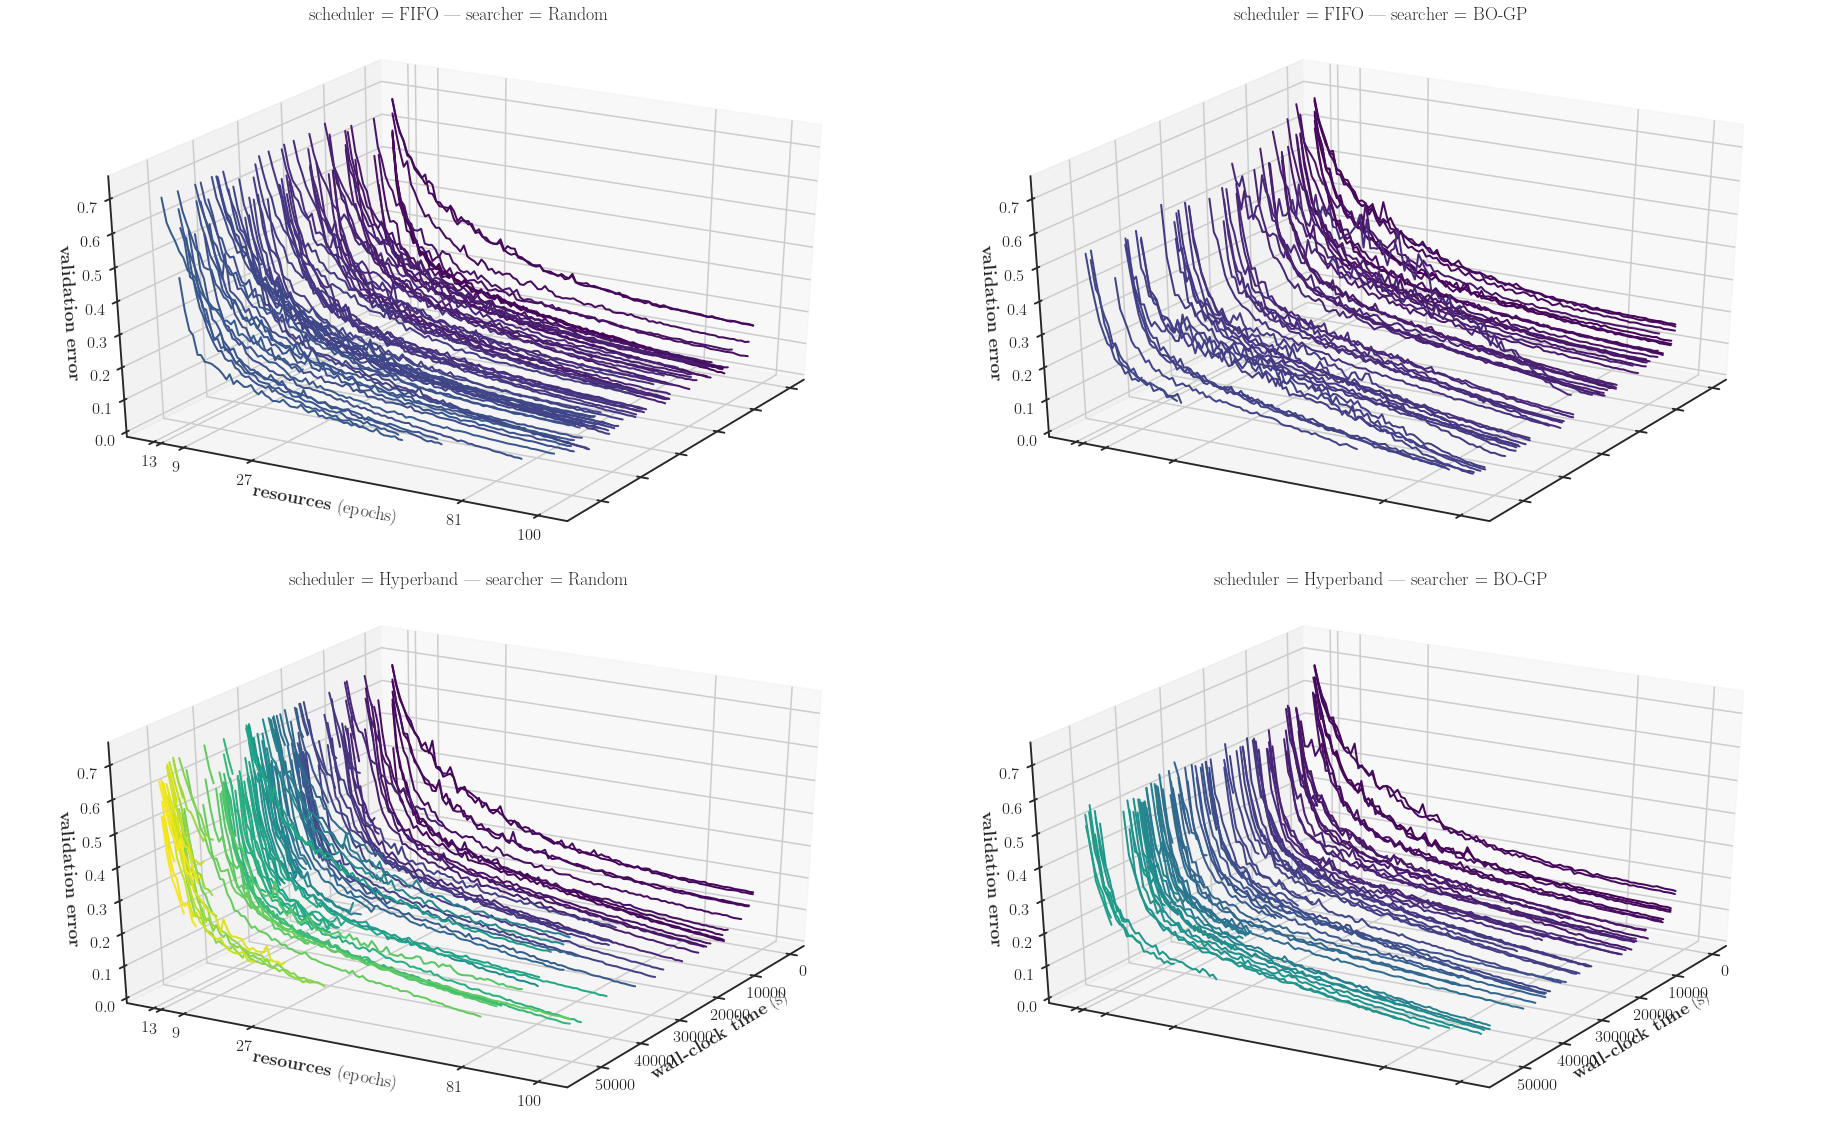

In [101]:
scheduler_name_mapping = {
    "fifo": "FIFO",
    "hyperband_stopping": "Hyperband",
}

searcher_name_mapping = {
    "random": "Random",
    "model_kernel_exp-decay-combined": "BO-GP",
}

pub_data = data.assign(scheduler=data.scheduler.map(scheduler_name_mapping),
                       searcher=data.searcher.map(searcher_name_mapping),
                       workers=data.num_nodes.str.extract("num_nodes_(\d+)"))

g = sns.FacetGrid(pub_data, row="scheduler", col="searcher",
                  hue="task_id", palette="viridis",
                  height=8, aspect=golden_ratio,
                  subplot_kws=dict(projection="3d", azim=30, elev=30))
g.map(plt.plot, "runtime", "epoch", "error", linewidth=2.0)
g.map_dataframe(fn)
g.set_xlabels(r"\textbf{wall-clock time} (s)")
g.set_ylabels(r"\textbf{resources} (epochs)")
g.set(zlabel=r"\textbf{validation error}")
g.set(yticks=resources, zlim=(0, 0.75))
plt.savefig(str(figures_dir.joinpath("roadmap.pdf")))
plt.savefig(str(figures_dir.joinpath("roadmap.png")))